In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"  # NOTE: This is different from the Medium post!
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [4]:
# Downlaod data
!kaggle datasets download -d arunrk7/surface-crack-detection

 97% 226M/233M [00:05<00:00, 49.3MB/s]
100% 233M/233M [00:05<00:00, 44.2MB/s]


In [5]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: Positive/15002_1.jpg    
  inflating: Positive/15003_1.jpg    
  inflating: Positive/15004_1.jpg    
  inflating: Positive/15005_1.jpg    
  inflating: Positive/15006_1.jpg    
  inflating: Positive/15007_1.jpg    
  inflating: Positive/15008_1.jpg    
  inflating: Positive/15009_1.jpg    
  inflating: Positive/15010_1.jpg    
  inflating: Positive/15011_1.jpg    
  inflating: Positive/15012_1.jpg    
  inflating: Positive/15013_1.jpg    
  inflating: Positive/15014_1.jpg    
  inflating: Positive/15015_1.jpg    
  inflating: Positive/15016_1.jpg    
  inflating: Positive/15017_1.jpg    
  inflating: Positive/15018_1.jpg    
  inflating: Positive/15019_1.jpg    
  inflating: Positive/15020_1.jpg    
  inflating: Positive/15021_1.jpg    
  inflating: Positive/15022_1.jpg    
  inflating: Positive/15023_1.jpg    
  inflating: Positive/15024_1.jpg    
  inflating: Positive/15025_1.jpg    
  inflating: Positive/15026_1.jpg    

In [6]:
! apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
openjdk version "11.0.6" 2020-01-14
OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)


In [7]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import datetime
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

import os
import itertools
from glob import glob
from PIL import Image
from matplotlib.pyplot import imshow

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization


Using TensorFlow backend.


In [9]:
ls /content

adc.json  Negative/  Positive/  sample_data/  surface-crack-detection.zip


In [10]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# dataframe  id  label  image-array

base_crack_Negative = "Negative"
base_crack_Positive = "Positive"

crack_Negative_df = pd.DataFrame(columns=( 'path', 'image', 'label'),index=np.arange(0,20000))
crack_Positive_df = pd.DataFrame(columns=( 'path', 'image', 'label'),index=np.arange(0,20000))

imageid_path_dict_Negative = np.array([x for x in glob(os.path.join(base_crack_Negative, '*.jpg'))])
imageid_path_dict_Positive = np.array([x for x in glob(os.path.join(base_crack_Positive, '*.jpg'))])

crack_Negative_df['path']=imageid_path_dict_Negative
crack_Negative_df['label']=0
crack_Negative_df['image']=crack_Negative_df['path'].map(lambda x: np.asarray(Image.open(x).resize((75,100))))

crack_Positive_df['path']=imageid_path_dict_Positive
crack_Positive_df['label']=1
crack_Positive_df['image']=crack_Positive_df['path'].map(lambda x: np.asarray(Image.open(x).resize((75,100))))

print("Negative:",crack_Negative_df["image"][0].shape)
print("Positive:",crack_Positive_df["image"][0].shape)

print(imageid_path_dict_Negative.shape,imageid_path_dict_Positive.shape)

crack_df = crack_Negative_df.append(crack_Positive_df)  # 将两个dataframe合并
crack_df.reset_index(drop=True,inplace=True)  # 重置检索
print(crack_df.shape)

Negative: (100, 75, 3)
Positive: (100, 75, 3)
(20000,) (20000,)
(40000, 3)


In [0]:
features=crack_df.drop(columns=['label'],axis=1)
target=crack_df["label"]

x_train_o, x_test_o, y_train, y_test = train_test_split(features, target, test_size=0.20,random_state=1234)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Reshape image in 3 dimensions (height = 100px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))

In [12]:
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")              # FOR TENSORBOARD
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)  # FOR TENSORBOARD

model.fit(x_train, y_train, validation_split=0.1,epochs=20, batch_size=256, callbacks=[tensorboard_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 25, 64)        0

In [13]:
history = model.history
print(history.history)

{'loss': [0.16342304998594853, 0.018827670615994267, 0.01605898286319441, 0.017445357997591296, 0.012618675755543842, 0.01019589484255347, 0.009811721621339933, 0.008950468304360078, 0.007491051396096332, 0.007256914174779215, 0.0059376986361651994, 0.0069675734226540146, 0.00521905555557977, 0.003384042613001333, 0.004567937558749691, 0.002812165657006618, 0.002142564996611327, 0.0018845658119890788, 0.002681441842513676, 0.002269688539939428], 'accuracy': [0.92618054, 0.9940278, 0.9944792, 0.99430555, 0.99618053, 0.99722224, 0.9970833, 0.9971875, 0.9978472, 0.99753475, 0.9984375, 0.99788195, 0.9985764, 0.9990278, 0.9988889, 0.99916667, 0.9993403, 0.9995833, 0.9990625, 0.99927086], 'val_loss': [0.03757803663611412, 0.01221356140449643, 0.00858146337326616, 0.011834032870829105, 0.019478839803487063, 0.006479652787093073, 0.011444858685135841, 0.00636660645599477, 0.00715861271484755, 0.012204202151624486, 0.006544161336205434, 0.018152938103303314, 0.005156163572682999, 0.008130255723

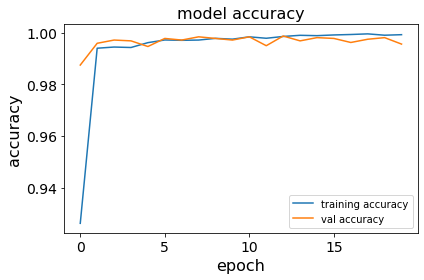

In [14]:
fig, ax = plt.subplots()

ax.plot(history.history['accuracy'],label='training accuracy')
ax.plot(history.history['val_accuracy'],label='val accuracy')

ax.set_title('model accuracy',{'size':16})
ax.set_xlabel('epoch',{'size':16})
ax.set_ylabel('accuracy',{'size':16})
              
plt.tick_params(labelsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

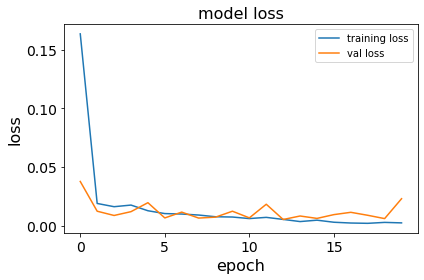

In [15]:
fig, ax = plt.subplots()

ax.plot(history.history['loss'],label='training loss')
ax.plot(history.history['val_loss'],label='val loss')

ax.set_title('model loss',{'size':16})
ax.set_xlabel('epoch',{'size':16})
ax.set_ylabel('loss',{'size':16})
              
plt.tick_params(labelsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

confusion_matrix
 [[3959    2]
 [  41 3998]]
accuracy:0.994625
precision:0.9995
recall:0.98984897251795
f1-score:0.9946510760044782


Text(33.0, 0.5, 'True')

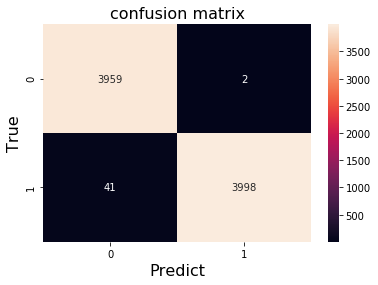

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score

y_score = model.predict_classes(x_test)
y_score_1 = model.predict(x_test)

import seaborn as sns
%matplotlib inline
cm = confusion_matrix(y_test, y_score)
print('confusion_matrix\n', cm)

print('accuracy:{}'.format(accuracy_score(y_test, y_score)))
print('precision:{}'.format(precision_score(y_test, y_score)))
print('recall:{}'.format(recall_score(y_test, y_score)))
print('f1-score:{}'.format(f1_score(y_test, y_score)))

f,ax=plt.subplots()
sns.heatmap(cm,annot=True,ax=ax,fmt='.4g') #画热力图

ax.set_title('confusion matrix',fontsize=16) #标题
ax.set_xlabel('Predict',fontsize=16) #x轴
ax.set_ylabel('True',fontsize=16) #y轴

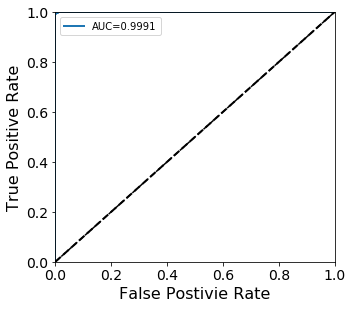

In [17]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 4.4))
# AUC值
auc = roc_auc_score(y_test,y_score_1)
# 画ROC曲线
fpr, tpr, thresholds = roc_curve(y_test,y_score_1)   
ax.plot(fpr, tpr, linewidth = 2,label='AUC=%.4f' % auc)
ax.plot([0,1],[0,1], 'k--')


ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('False Postivie Rate',{'size':16})
ax.set_ylabel('True Positive Rate',{'size':16})

ax.plot([0,1],[0,1], 'k--',lw=2)

plt.tick_params(labelsize=14)

plt.legend()
plt.tight_layout()
plt.show()

In [18]:
y_score_1

array([[1.0000000e+00],
       [2.4293104e-05],
       [1.6385986e-05],
       ...,
       [4.8432173e-07],
       [1.5813688e-05],
       [1.0000000e+00]], dtype=float32)

In [19]:
ls Negative

00001.jpg  02859.jpg  05717.jpg  08575.jpg  11433.jpg  14291.jpg  17149.jpg
00002.jpg  02860.jpg  05718.jpg  08576.jpg  11434.jpg  14292.jpg  17150.jpg
00003.jpg  02861.jpg  05719.jpg  08577.jpg  11435.jpg  14293.jpg  17151.jpg
00004.jpg  02862.jpg  05720.jpg  08578.jpg  11436.jpg  14294.jpg  17152.jpg
00005.jpg  02863.jpg  05721.jpg  08579.jpg  11437.jpg  14295.jpg  17153.jpg
00006.jpg  02864.jpg  05722.jpg  08580.jpg  11438.jpg  14296.jpg  17154.jpg
00007.jpg  02865.jpg  05723.jpg  08581.jpg  11439.jpg  14297.jpg  17155.jpg
00008.jpg  02866.jpg  05724.jpg  08582.jpg  11440.jpg  14298.jpg  17156.jpg
00009.jpg  02867.jpg  05725.jpg  08583.jpg  11441.jpg  14299.jpg  17157.jpg
00010.jpg  02868.jpg  05726.jpg  08584.jpg  11442.jpg  14300.jpg  17158.jpg
00011.jpg  02869.jpg  05727.jpg  08585.jpg  11443.jpg  14301.jpg  17159.jpg
00012.jpg  02870.jpg  05728.jpg  08586.jpg  11444.jpg  14302.jpg  17160.jpg
00013.jpg  02871.jpg  05729.jpg  08587.jpg  11445.jpg  14303.jpg  17161.jpg
00014.jpg  0

In [20]:
%tensorboard --logdir logs/fit

TESTING THE MODEL!!!!!!!!!!!

[[0.9999999]]


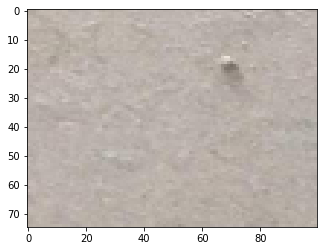

In [29]:
img_path = 'Negative/08397.jpg'

img = image.load_img(img_path, target_size=(75, 100))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(model.predict(x))

['14150_1.jpg', '07746.jpg', '10078_1.jpg', '11666_1.jpg', '17117_1.jpg', '11156_1.jpg', '11245_1.jpg', '09725.jpg', '04823.jpg', '11536_1.jpg', '03180.jpg', '02274.jpg', '16716_1.jpg', '07500.jpg', '16747_1.jpg', '01752.jpg', '18538_1.jpg', '10120_1.jpg', '14897_1.jpg', '14211_1.jpg', '03333.jpg', '13309_1.jpg', '07344.jpg', '01582.jpg', '17828_1.jpg', '04117.jpg', '01963.jpg', '01025.jpg', '12391_1.jpg', '13519_1.jpg', '12364_1.jpg', '03603.jpg', '17077_1.jpg', '13474_1.jpg', '08514.jpg', '12932_1.jpg', '16799_1.jpg', '08625.jpg', '17090_1.jpg', '00582.jpg', '15019_1.jpg', '03836.jpg', '10300_1.jpg', '15928_1.jpg', '12510_1.jpg', '10570_1.jpg', '04539.jpg', '02698.jpg', '10883_1.jpg', '06677.jpg', '08822.jpg', '05996.jpg', '15680_1.jpg', '03675.jpg', '13341_1.jpg', '04128.jpg', '19567.jpg', '19735.jpg', '00353.jpg', '13106_1.jpg', '15692_1.jpg', '17554_1.jpg', '16728_1.jpg', '18646_1.jpg', '04148.jpg', '14561_1.jpg', '02039.jpg', '07764.jpg', '09024.jpg', '02132.jpg', '04950.jpg', '0

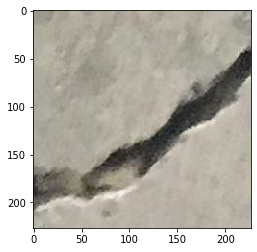

<Figure size 432x288 with 0 Axes>

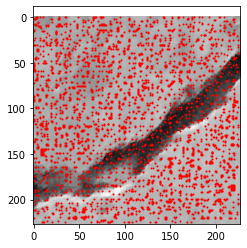

In [45]:
import time
import heapq as hq
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000

import os
print(os.listdir("Positive")) #Liste fichiers

"""Importation de l'image et conversion en array"""
from PIL import Image
img = Image.open( "Positive/08122.jpg")
img.load()
data = np.asarray( img, dtype="int32" )

"""Affichage Image"""
plt.imshow(img)
plt.show()

#Conversion en tableau 2D (moyenne des valeurs RGB)
data = np.sum(data, axis = 2) / 3 
plt.gray()
#Image en nuance
#sns.heatmap(data = data)
fig, ax = plt.subplots()
ax.imshow(data)
tailleCase = 5
    
intensities = []
positions = []

ligPlot = []
colPlot = []

for lig in range(data.shape[0] // tailleCase):
    for col in range(data.shape[1] // tailleCase):
        posLig, posCol = lig*tailleCase, col*tailleCase
        mini = data[posLig:posLig+tailleCase,posCol:posCol+tailleCase].min()
        reponse = np.where(data[posLig:posLig+tailleCase,posCol:posCol+tailleCase] == mini)
        
        rep = list(zip(reponse[0], reponse[1]))
        for dLig, dCol in rep:
            ligPlot.append(posLig + dLig)
            colPlot.append(posCol + dCol)
            
            positions.append((posLig + dLig, posCol + dCol))
            intensities.append(mini)

ax.scatter(colPlot, ligPlot, s = 1, color = 'r')
plt.show()

In [46]:
print("Before point selection", len(positions))
threshold = np.mean(intensities) - np.std(intensities)

for index in range(len(intensities) -1, -1, -1):
    if intensities[index] >= threshold: 
        del intensities[index]
        del positions[index]

print("Afterpoint selection", len(positions))

Before point selection 3417
Afterpoint selection 377


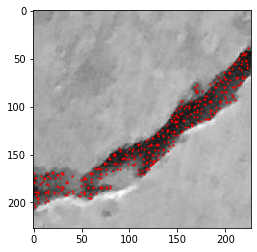

0.19576597213745117


In [47]:
start = time.time() 

ligPlot = [i[0] for i in positions]
colPlot = [i[1] for i in positions]

fig, ax = plt.subplots()
ax.imshow(data)
ax.scatter(colPlot, ligPlot, s = 1, color = 'r')
plt.show()

print(time.time() - start)

Process: 1 / 377 - 0.0 %
Process: 2 / 377 - 0.2652519893899204 %
Process: 3 / 377 - 0.5305039787798408 %
Process: 4 / 377 - 0.7957559681697612 %
Process: 5 / 377 - 1.0610079575596816 %
Process: 6 / 377 - 1.3262599469496021 %
Process: 7 / 377 - 1.5915119363395225 %
Process: 8 / 377 - 1.8567639257294428 %
Process: 9 / 377 - 2.122015915119363 %
Process: 10 / 377 - 2.3872679045092835 %
Process: 11 / 377 - 2.6525198938992043 %
Process: 12 / 377 - 2.9177718832891246 %
Process: 13 / 377 - 3.183023872679045 %
Process: 14 / 377 - 3.4482758620689653 %
Process: 15 / 377 - 3.7135278514588856 %
Process: 16 / 377 - 3.978779840848806 %
Process: 17 / 377 - 4.244031830238726 %
Process: 18 / 377 - 4.509283819628647 %
Process: 19 / 377 - 4.774535809018567 %
Process: 20 / 377 - 5.039787798408488 %
Process: 21 / 377 - 5.305039787798409 %
Process: 22 / 377 - 5.570291777188329 %
Process: 23 / 377 - 5.835543766578249 %
Process: 24 / 377 - 6.10079575596817 %
Process: 25 / 377 - 6.36604774535809 %
Process: 26 /

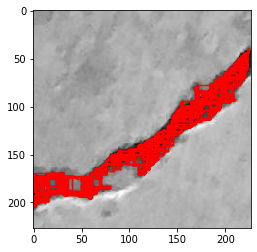

In [48]:
colorList = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'chocolate', 'deepskyblue', 'lime', 'orange']
#print("Positions number:", len(positions))

pathIntensities = []
paths = []
ligPlot, colPlot = [], []

for indexPos, (startLig, startCol) in enumerate(positions):
    ax.scatter(startCol, startLig, s = 10, color = 'r')
    vu = 0
    copyPositions = [(lig, col) for lig, col in positions]
    
    print("Process:", indexPos+1, "/", len(positions), "-", indexPos/len(positions)*100, "%")
    
    queue = [(data[startLig][startCol], startLig, startCol)]
    distance = [ [float("inf") for i in range(data.shape[1])] for a in range(data.shape[0])]
    predecessor = [ [(-1,-1) for i in range(data.shape[1])] for a in range(data.shape[0])]

    while queue and vu < 20 : #!= len(positions) :
        intensity, lig, col = hq.heappop(queue)
        if intensity > distance[lig][col]: continue
        
        if (lig,col) in copyPositions:
            vu += 1
            copyPositions.remove((lig,col))
        
        for dLig, dCol in [(1,0),(-1,0),(0,1),(0,-1)]:
            newLig, newCol = lig + dLig, col + dCol
            if not(0 <= newLig < data.shape[0] and 0 <= newCol < data.shape[1]): continue

            newIntensity = intensity + data[newLig][newCol]
            if distance[newLig][newCol] > newIntensity:
                distance[newLig][newCol] = newIntensity
                predecessor[newLig][newCol] = (lig, col)
                hq.heappush(queue, (newIntensity, newLig, newCol))
    
    for endLig, endCol in positions[indexPos+1:]:
        l, c = endLig, endCol
        
        if distance[l][c] == float("inf"): continue
        
        curLig = []
        curCol = []
        
        while (l,c) != (startLig, startCol):
            curLig.append(l)
            curCol.append(c)
            
            nL, nC = predecessor[l][c]
            l,c = nL, nC 
        
        ligPlot.extend(curLig)
        colPlot.extend(curCol)
        
        paths.append((curLig, curCol))
        pathIntensities.append(distance[endLig][endCol])

        
fig, ax = plt.subplots()
ax.imshow(data)
ax.scatter(colPlot, ligPlot, s = 0.2, c = 'r')
plt.show()

SAVING TF2 MODEL

In [0]:
checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
model.save_weights("weights")

In [62]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [69]:
v = tf.Variable(0, name='my_variable')
sess = tf.compat.v1.Session()
tf.io.write_graph(sess.graph, '/tmp/my-model', 'train.pbtxt')

'/tmp/my-model/train.pbtxt'

In [1]:
ls /content/saved_model

ls: cannot access '/content/saved_model': No such file or directory


In [72]:
# Jean Vitor de Paulo Blog - https://jeanvitor.com/tensorflow-object-detecion-opencv/
 
import cv2
 
# Load a model imported from Tensorflow
tensorflowNet = cv2.dnn.readNetFromTensorflow("/content/saved_model/my_model/saved_model.pb", "/tmp/my-model/train.pbtxt")
 
# Input image
img = cv2.imread('img.jpg')
rows, cols, channels = img.shape
 
# Use the given image as input, which needs to be blob(s).
tensorflowNet.setInput(cv2.dnn.blobFromImage(img, size=(300, 300), swapRB=True, crop=False))
 
# Runs a forward pass to compute the net output
networkOutput = tensorflowNet.forward()
 
# Loop on the outputs
for detection in networkOutput[0,0]:
    
    score = float(detection[2])
    if score > 0.2:
    	
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
 
        #draw a red rectangle around detected objects
        cv2.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (0, 0, 255), thickness=2)
 
# Show the image with a rectagle surrounding the detected objects 
cv2.imshow('Image', img)
cv2.waitKey()
cv2.destroyAllWindows()

error: ignored

CV2

In [50]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to the input image")
ap.add_argument("-w", "--width", type=float, required=True,
	help="width of the left-most object in the image (in inches)")
args = vars(ap.parse_args())
# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None
# loop over the contours individually
for c in cnts:
	# if the contour is not sufficiently large, ignore it
	if cv2.contourArea(c) < 100:
		continue
	# compute the rotated bounding box of the contour
	orig = image.copy()
	box = cv2.minAreaRect(c)
	box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
	box = np.array(box, dtype="int")
	# order the points in the contour such that they appear
	# in top-left, top-right, bottom-right, and bottom-left
	# order, then draw the outline of the rotated bounding
	# box
	box = perspective.order_points(box)
	cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
	# loop over the original points and draw them
	for (x, y) in box:
		cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
	# unpack the ordered bounding box, then compute the midpoint
	# between the top-left and top-right coordinates, followed by
	# the midpoint between bottom-left and bottom-right coordinates
	(tl, tr, br, bl) = box
	(tltrX, tltrY) = midpoint(tl, tr)
	(blbrX, blbrY) = midpoint(bl, br)
	# compute the midpoint between the top-left and top-right points,
	# followed by the midpoint between the top-righ and bottom-right
	(tlblX, tlblY) = midpoint(tl, bl)
	(trbrX, trbrY) = midpoint(tr, br)
	# draw the midpoints on the image
	cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
	# draw lines between the midpoints
	cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
		(255, 0, 255), 2)
	cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
		(255, 0, 255), 2)
	# compute the Euclidean distance between the midpoints
	dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
	dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
	# if the pixels per metric has not been initialized, then
	# compute it as the ratio of pixels to supplied metric
	# (in this case, inches)
	if pixelsPerMetric is None:
		pixelsPerMetric = dB / args["width"]
	# compute the size of the object
	dimA = dA / pixelsPerMetric
	dimB = dB / pixelsPerMetric
	# draw the object sizes on the image
	cv2.putText(orig, "{:.1f}in".format(dimA),
		(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
	cv2.putText(orig, "{:.1f}in".format(dimB),
		(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
	# show the output image
	cv2.imshow("Image", orig)
	cv2.waitKey(0)

usage: ipykernel_launcher.py [-h] -i IMAGE -w WIDTH
ipykernel_launcher.py: error: the following arguments are required: -i/--image, -w/--width


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Image yükleyip test etmek için solda Files Menüsünden upload et# Modeli drove a kaydettim. Bilgisayara indiriyorum. Daha sonra bunu json a çeviricem. CMD açıp önce klasöre gidiyorum Ö: cd C:/Users/TaMeR/Desktop/Data SCIENCE/Skin Cancer/ daha sonra tensorflowjs_converter --input_format=keras model.h5 tfjs_model . Şimdi tensorflow json modeline çevirip kaydetti. Klasörünü açıyorum. Gerekli dosyalar orda.

Convert the model from Keras to Tensorflowjs
The conversion code below no longer works in kaggle kernels. I've left it in for reference.

In order to convert this model the workaround is as follows:

Recreate the model using native Keras.
Use the command line conversion process to convert the model from Keras to Tensorflowjs.
Here's how to do that: https://www.youtube.com/watch?v=Kc2_x6pBYGE
The above steps can be done in a kaggle kernel quite easily. Tensorflowjs is still fairly new so these type of bugs are not unusual.


Resources
These are some resources that I used:

Excellent tutorial series by deeplizard on how to use Mobilenet with Tensorflow.js
https://www.youtube.com/watch?v=HEQDRWMK6yY

Tutorial by Minsuk Heo on Accuracy, Precision and F1 Score
https://www.youtube.com/watch?v=HBi-P5j0Kec

Tutorial by Data School on how to evaluate a classifier
https://www.youtube.com/watch?v=85dtiMz9tSo

Tensorflow.js gallery of projects
https://github.com/tensorflow/tfjs/blob/master/GALLERY.md

Conclusion